In [1]:
####################################
##
## model_turnover
##
## Physical modelling of a turnover at long wavelengths, below 5 MHz.
##
## Created by Ravi; included to the pyGMOSS repo 29 June 2023
##
####################################


import numpy as np
import matplotlib.pyplot as plt
import math
from math import exp, sqrt
from scipy import interpolate
from scipy.special import gamma
import healpy as hp
import scipy.constants
from pygdsm import GlobalSkyModel16

PI = scipy.constants.pi
CVEL = scipy.constants.c
m_e = scipy.constants.m_e
EE = exp(1.0)
KB = scipy.constants.k
q_e = scipy.constants.elementary_charge

print ("PI, EE: ",PI,EE)
print ("CVEL, KB: ",CVEL,KB)
print ("m_e, q_e: ",m_e,q_e)

### frequency array in MHz
freq = np.logspace(np.log10(0.1), np.log10(2000.0), num=1000, \
                         endpoint=True, base=10.0, dtype=float, axis=0)
print("\nFreq start, start+1, end-1, end: ",freq[0],freq[1],freq[-2],freq[-1])

freq_Hz = freq * 1e6


PI, EE:  3.141592653589793 2.718281828459045
CVEL, KB:  299792458.0 1.380649e-23
m_e, q_e:  9.1093837015e-31 1.602176634e-19

Freq start, start+1, end-1, end:  0.1 0.1009962701490044 1980.2711496665283 2000.0000000000002


Generate spectra at healpix with nside, npix, resol (arcmin):  8 768 439.74226071262797


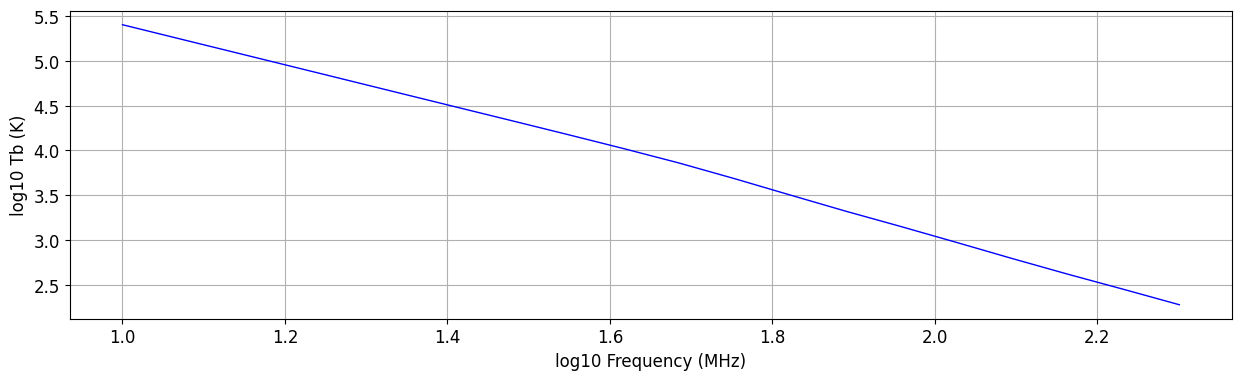

Temperature spectral index:  -2.410730709448796
Reference Freq, Tb:  200.0 189.12273


In [2]:
### Define Nested Healpix sky
###

NSIDE = 8

npix = hp.pixelfunc.nside2npix(NSIDE)
resol = hp.pixelfunc.nside2resol(NSIDE,arcmin=True)
print("Generate spectra at healpix with nside, npix, resol (arcmin): ",NSIDE, npix, resol)

### Load in GDSM sky model
###

## Get GSM model as array of healpix images
## of nside_out

def gsmodel(Frequency_MHz):
    
    nside_out = NSIDE
    gsm_2016 = GlobalSkyModel16(freq_unit='MHz',interpolation='pchip')
    
    if np.ndim(Frequency_MHz)==0:
        gsmap = gsm_2016.generate(Frequency_MHz)
        gsmap = hp.pixelfunc.ud_grade(gsmap, nside_out, pess=False, order_in='RING', \
                        order_out='RING', power=None, dtype=None)
        nside = hp.pixelfunc.get_nside(gsmap)
        npix = hp.pixelfunc.get_map_size(gsmap)
        resol = hp.pixelfunc.nside2resol(nside,arcmin=True)
        #print("Derived global sky map at freq ",Frequency_MHz," MHz with resolution: ",resol,\
        #" arcmin and ",npix," pixels.")
        
    else:
        gsmap = []
        for freq in Frequency_MHz:
            cgsmap = gsm_2016.generate(freq)
            cgsmap = hp.pixelfunc.ud_grade(cgsmap, nside_out, pess=False, order_in='RING', \
                            order_out='NESTED', power=None, dtype=None)
            nside = hp.pixelfunc.get_nside(cgsmap)
            npix = hp.pixelfunc.get_map_size(cgsmap)
            resol = hp.pixelfunc.nside2resol(nside,arcmin=True)
            #print("Derived global sky map at freq ",freq," MHz with resolution: ",resol,\
            #" arcmin and ",npix," pixels.")
            gsmap.append(cgsmap)
            
    return gsmap

freq2 = np.logspace(np.log10(10), np.log10(200.0), num=20, \
                         endpoint=True, base=10.0, dtype=float, axis=0)
gsmap  = gsmodel(freq2) 
#print("Shape of gsmap: ",np.shape(gsmap))

T_mean = np.mean(gsmap,axis=1)
#print("Shape of T_mean: ",np.shape(T_mean))

plt.figure(figsize=[15,4])
plt.rcParams.update({'font.size': 12})
ax1=plt.subplot(1,1,1)
ax1.plot(np.log10(freq2),np.log10(T_mean),"b-", linewidth=1) 
plt.ylabel('log10 Tb (K)')
plt.xlabel('log10 Frequency (MHz)')
plt.grid()
plt.show()

## Fit a straight line to get a spectral index
zz = np.polyfit(np.log10(freq2),np.log10(T_mean), 1)
print("Temperature spectral index: ",zz[0])
Total_T_spectralindex = zz[0]

Total_freq_ref = 200.0 # MHz
ref_index = (np.abs(freq2 - Total_freq_ref)).argmin()
Total_T_ref = T_mean[ref_index]
print("Reference Freq, Tb: ",Total_freq_ref,Total_T_ref)
Total_T = Total_T_ref * (freq/Total_freq_ref)**Total_T_spectralindex



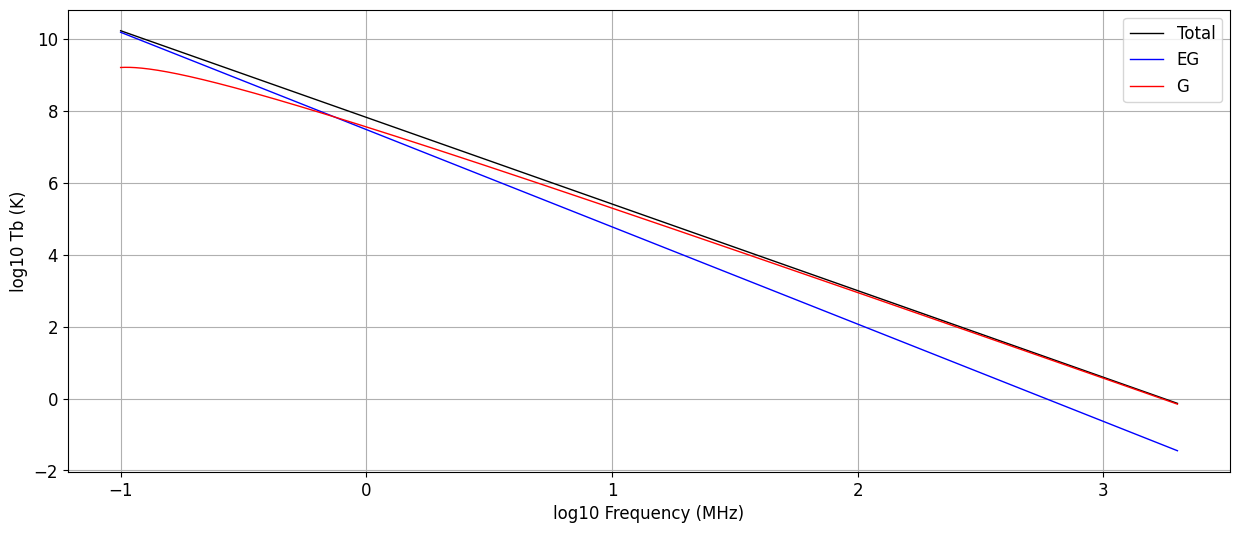

In [3]:
## Define the extragalactic spectrum
##
EG_freq_ref = 610.0 # MHz
EG_T_ref = 0.880  # Temperature in kelvin at the rerefence freq
EG_spectralindex = -2.707  # temperature spectral index
##
####################################

EG_T = EG_T_ref * (freq/EG_freq_ref)**EG_spectralindex

## Derive the Galactic contribution by subtracting the EG from Total.

G_T = Total_T - EG_T

plt.figure(figsize=[15,6])
plt.rcParams.update({'font.size': 12})
ax1=plt.subplot(1,1,1)

xx = np.log10(freq)

yy1 = np.log10(Total_T) 
yy2 = np.log10(EG_T)
yy3 = np.log10(G_T)

ax1.plot((xx),(yy1),"k-", linewidth=1,label='Total') 
ax1.plot((xx),(yy2),"b-", linewidth=1,label='EG') 
ax1.plot((xx),(yy3),"r-", linewidth=1,label='G') 
plt.ylabel('log10 Tb (K)')
plt.xlabel('log10 Frequency (MHz)')
plt.grid()
plt.legend(loc='best')
plt.show()

In [4]:

### The input EG spectral index
alpha1 = EG_spectralindex  # temperature spectral index
ss1 = -alpha1-2 # intensity spectral index s
pp1 = 2*ss1+1 # electron energy spectral index p

### Assumptions
#Bmag = 1e-9 # 1e-9  # Tesla == 10 micro-Gauss
#sin_alph = 1.0

### Derived constants for the synchrotron self absorption
#C1 = (gamma((pp1/4)+(19/12))*gamma((pp1/4)+(1/12))) / (gamma((3*pp1+2)/12)*gamma((3*pp1+22)/12)) 
#C2 = PI**((pp1-4)/2) * CVEL**(3*(pp1-2)/2) * m_e**((pp1+1)/2) / sqrt(6*q_e*Bmag*sin_alph)
#C3 = C1*C2
#print("Constants: ",C1,C2,C3)

## define the long-wavelength thermal turnover frequency for the Galactic emission
freq_turn_FF = 1.5 # MHz
Tism = 8000 # K diffuse ISM thermal temperature

## define the long wavelength SSA turnover
freq_turn_NT = 3.5 # MHz
alpha_thin = alpha1 + 2.0  # Intensity spectral index; high frequency optically thin part
alpha_thick = 2.5  # Intensity spectral index; low frequency optically thick part


In [5]:

## Define a normalised EG intensity spectrum to start with
S_m = 1.0
tau_m = 1.5*( sqrt(1-8*alpha_thin/(3*alpha_thick)) - 1 )
F_NTH_initial = S_m * (freq/freq_turn_NT)**alpha_thick * \
    (1-np.exp(-tau_m*(freq/freq_turn_NT)**(alpha_thin-alpha_thick)))/(1-exp(-tau_m))

## Then normalize using ratio of intensities at the highest frequency
### EG intensity spectrum without SSA
EG_F = np.multiply( 2.0*KB*(freq_Hz)**2/(CVEL*CVEL), EG_T)
## EG intensity spectrum with SSA
S_m = EG_F[-1]/F_NTH_initial[-1]
F_NTH = S_m*F_NTH_initial

### Model the source function for the extragalactic emission
#S_NTH = C3*(freq_Hz**2.5)
### and derive the EG spectrum corrected for self absorption, dividing the intensity into NN parts in depth
#NN = 1000
#F_NTH = 0.0
#F1n = F1/NN
#for i in range (NN):
#    opacity_nonthermal = np.divide(F1n,S_NTH)
#    F_NTH = F_NTH*np.exp(-opacity_nonthermal) + S_NTH*(1-np.exp(-opacity_nonthermal))

T_NTH = np.multiply( (CVEL*CVEL)/(2.0*KB*(freq_Hz)**2), F_NTH )

## The extragalactic background is EG_T & EG_F without SSA; T_NTH, F_NTH with SSA

## total spectrum before FF absorption is Galactic without FF, plus EG with SSA, plus CMB
T_Total = G_T + T_NTH + 2.7
F_Total = np.multiply( 2.0*KB*(freq_Hz)**2/(CVEL*CVEL), T_Total)

### Model thermal absorption turn over due to forground absorption by medium
### Ignore contribution from FF emission by Tism 
opacity_thermal = (freq_turn_FF/freq)**2.1
F_TH = F_Total*np.exp(-opacity_thermal)
T_TH = np.multiply( (CVEL*CVEL)/(2.0*KB*(freq_Hz)**2), F_TH )
#T_TH = T_Total*np.exp(-opacity_thermal) + Tism*(1-np.exp(-opacity_thermal))   ## temperature units
#F_TH = np.multiply( 2.0*KB*(freq_Hz)**2/(CVEL*CVEL), T_TH)              ## Flux density units

print("shapes of spectra: ",np.shape(F_TH),np.shape(F_NTH),np.shape(T_TH),np.shape(T_NTH))

## Frequency at which the total spectrum F_TH peaks:
print("Peak freq for total spectrum: ",freq[np.argmax(F_TH)])


shapes of spectra:  (1000,) (1000,) (1000,) (1000,)
Peak freq for total spectrum:  3.99562519644586


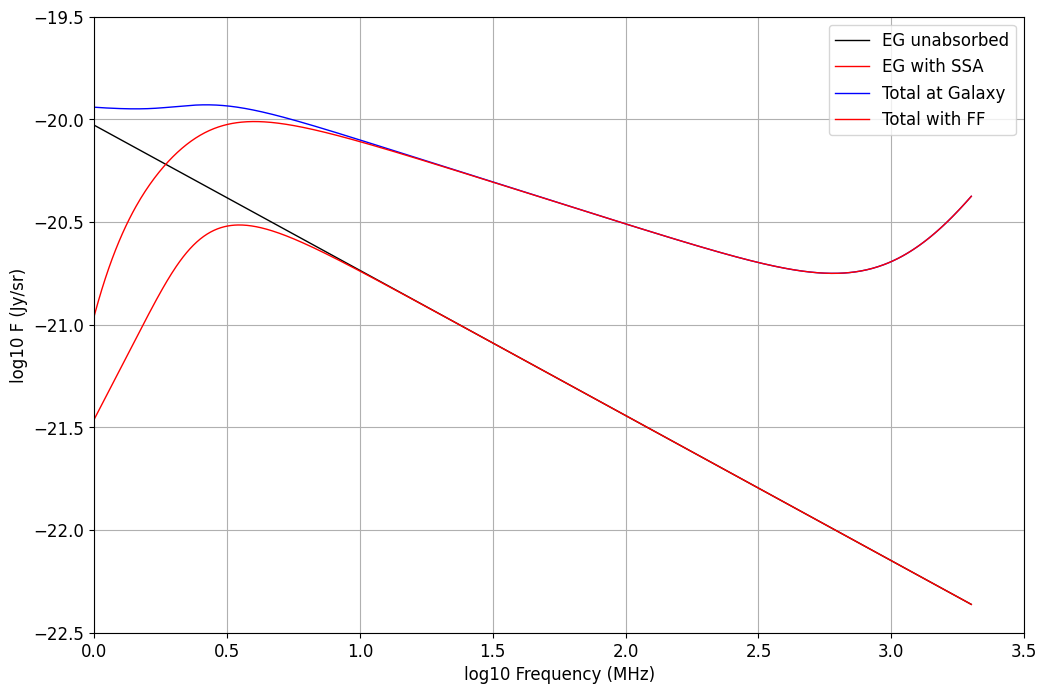

In [6]:
plt.figure(figsize=[12,8])
plt.rcParams.update({'font.size': 12})
ax1=plt.subplot(1,1,1)

xx = np.log10(freq)

yy0 = np.log10(EG_F)
yy1 = np.log10(F_Total)
yy2 = np.log10(F_NTH)
yy3 = np.log10(F_TH)
ax1.plot((xx),(yy0),"k-", linewidth=1,label='EG unabsorbed') 
ax1.plot((xx),(yy2),"r-", linewidth=1,label='EG with SSA') 
ax1.plot((xx),(yy1),"b-", linewidth=1,label='Total at Galaxy') 
ax1.plot((xx),(yy3),"r-", linewidth=1,label='Total with FF') 
plt.ylabel('log10 F (Jy/sr)')
plt.xlabel('log10 Frequency (MHz)')
plt.grid()
plt.legend(loc='best')
plt.xlim([0,3.5])
plt.ylim([-22.5,-19.5])
plt.show()

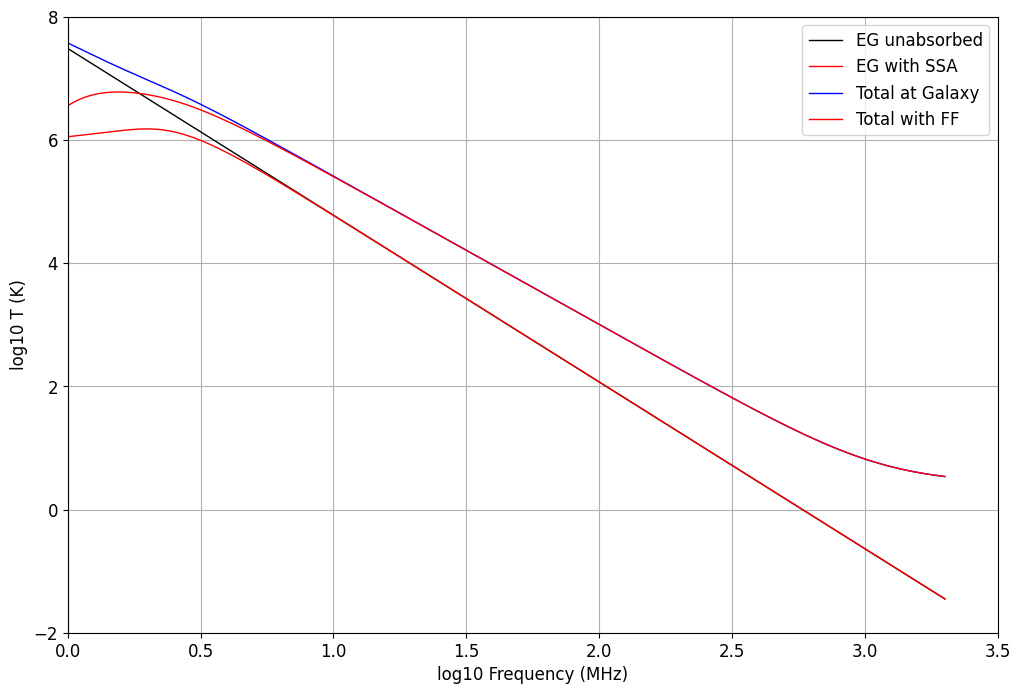

In [7]:
plt.figure(figsize=[12,8])
plt.rcParams.update({'font.size': 12})
ax1=plt.subplot(1,1,1)

xx = np.log10(freq)

yy0 = np.log10(EG_T)
yy1 = np.log10(T_Total)
yy2 = np.log10(T_NTH)
yy3 = np.log10(T_TH)
ax1.plot((xx),(yy0),"k-", linewidth=1,label='EG unabsorbed') 
ax1.plot((xx),(yy2),"r-", linewidth=1,label='EG with SSA') 
ax1.plot((xx),(yy1),"b-", linewidth=1,label='Total at Galaxy') 
ax1.plot((xx),(yy3),"r-", linewidth=1,label='Total with FF') 
plt.ylabel('log10 T (K)')
plt.xlabel('log10 Frequency (MHz)')
plt.grid()
plt.legend(loc='best')
plt.xlim([0,3.5])
plt.ylim([-2,8])
plt.show()